In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
nPerClass = 1000
imgSize = 91

x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)

widths = [1.8, 2.4]

images = torch.zeros(2*nPerClass, 1, imgSize, imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):
    ro = 2*np.random.randn(2) # random offset
    G = np.exp( -( (X - ro[0])**2 + (Y - ro[1])**2 ) / (2*widths[i%2]**2) ) # formula for Gaussian

    G = G + np.random.randn(imgSize, imgSize)/5 # adding noise

    images[i, :, :, :] = torch.Tensor(G).view(1, imgSize, imgSize)
    labels[i] = i%2

labels = labels[:, None]

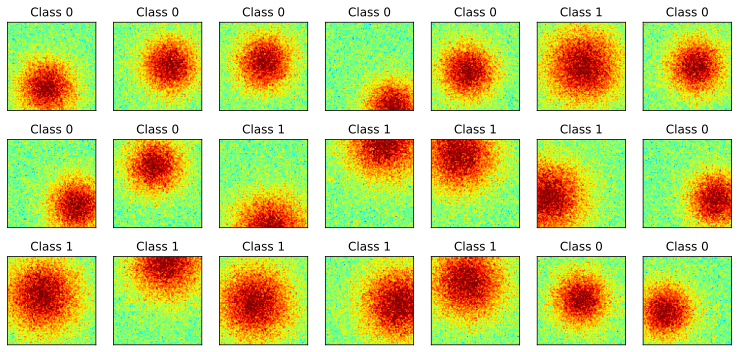

In [4]:
fig, axs = plt.subplots(3, 7, figsize = (13, 6))

for i, ax in enumerate(axs.flatten()):
    whichPic = np.random.randint(2*nPerClass)
    G = np.squeeze(images[whichPic, :, :])
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    ax.set_title('Class %s'%int(labels[whichPic].item()))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, train_size=0.9)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [8]:
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])


In [9]:
class Model(nn.Module):
    def __init__ (self):
        super().__init__()

        self.enc = nn.Sequential(
            nn.Conv2d(1, 6, 3, padding=1), # output image size = (91+2*1-3)/1 + 1 = 91
            nn.ReLU(),
            nn.AvgPool2d(2, 2),            # output image size = np.floor(91/2) = 45
            nn.Conv2d(6, 4, 3, padding=1), # output image size = (45+2*1-3)/1 + 1 = 45
            nn.ReLU(),
            nn.AvgPool2d(2, 2),            # output image size = np.floor(45/2) = 22
            nn.Flatten(),
            nn.Linear(4*22*22, 50),        # number of channels X height of image X width of image
            nn.Linear(50, 1)
        )
    def forward(self, x):
       return self.enc(x)

In [10]:
def getModel():
    CNN = Model()

    lossFunction = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(CNN.parameters(), lr=0.001)

    return CNN, lossFunction, optimizer

In [11]:
# testing model

CNN, lossFunction, optimizer = getModel()

X, y = next(iter(train_loader))
yHat = CNN(X)

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = lossFunction(yHat, y)
print(' ')
print('Loss:')
print(loss)



 
torch.Size([32, 1])
torch.Size([32, 1])
 
Loss:
tensor(0.6911, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [12]:
summary(CNN, (1, imgSize, imgSize))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─AvgPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─AvgPool2d: 2-6                    [-1, 4, 22, 22]           --
|    └─Flatten: 2-7                      [-1, 1936]                --
|    └─Linear: 2-8                       [-1, 50]                  96,850
|    └─Linear: 2-9                       [-1, 1]                   51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
Total mult-adds (M): 1.08
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─AvgPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─AvgPool2d: 2-6                    [-1, 4, 22, 22]           --
|    └─Flatten: 2-7                      [-1, 1936]                --
|    └─Linear: 2-8                       [-1, 50]                  96,850
|    └─Linear: 2-9                       [-1, 1]                   51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
Total mult-adds (M): 1.08
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84

In [14]:
def trainModel(CNN, lossFunction, optimizer):
    epochs = 10

    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    for _ in range(epochs):

        CNN.train()
        batchAcc = []
        batchLoss = []
        for x, y in train_loader:
            yHat = CNN.forward(x)
            
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean(((yHat > 0.5) == y).float())*100)

        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)

        CNN.eval()
        X, Y = next(iter(test_loader))

        with torch.no_grad():
            pred = CNN(X)

        testAcc.append(torch.mean(((pred > 0.5)==Y).float())*100)

    return trainAcc, testAcc, losses, CNN

In [15]:
CNN, lossFunction, optimizer = getModel()
trainAcc, testAcc, losses, CNN = trainModel(CNN, lossFunction, optimizer)

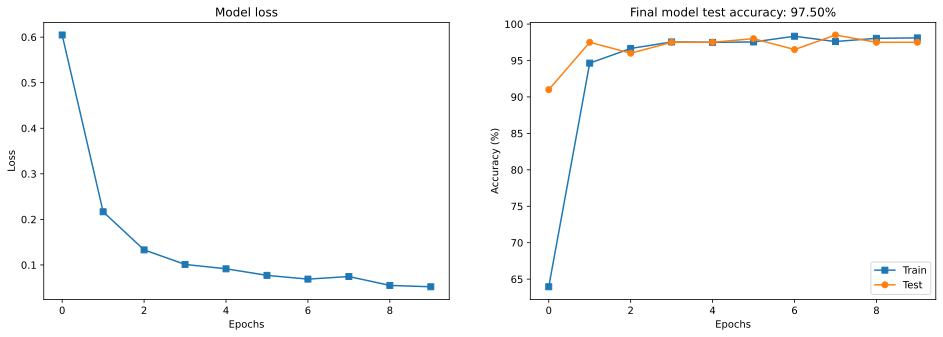

In [16]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

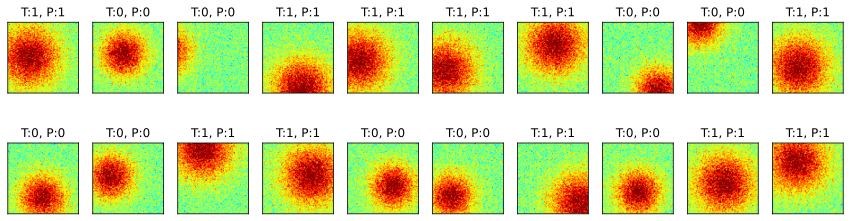

In [17]:
# visualize some images

X, y = next(iter(test_loader))
yHat = CNN(X)

fig, axs = plt.subplots(2, 10, figsize = (15, 4))

for i, ax in enumerate(axs.flatten()):
    G = torch.squeeze(X[i, :, :]).detach()
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    t = ( int(y[i].item()), int(yHat[i].item()>0.5))
    ax.set_title('T:%s, P:%s'%t)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [18]:
# visualize the filters
print(CNN)

layer1W = CNN.enc[0].weight
layer3W = CNN.enc[3].weight

print(' ')
print(layer1W.shape)
print(layer3W.shape)

Model(
  (enc): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1936, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)
 
torch.Size([6, 1, 3, 3])
torch.Size([4, 6, 3, 3])


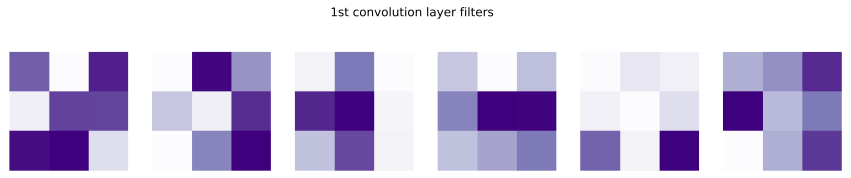

In [22]:
fig, axs = plt.subplots(1, 6, figsize = (15, 3))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(torch.squeeze(layer1W[i, :, :, :]).detach(), cmap='Purples')
    ax.axis('off')

plt.suptitle('1st convolution layer filters')
plt.show()

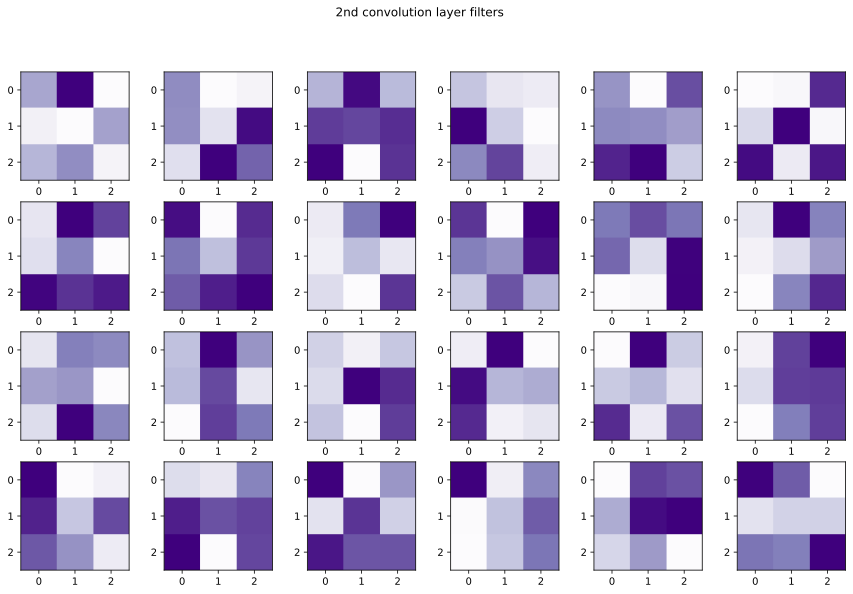

In [28]:
fig, axs = plt.subplots(4, 6, figsize = (15, 9))

for i in range(6*4):
    idx = np.unravel_index(i, (4, 6))
    axs[idx].imshow(torch.squeeze(layer3W[idx[0], idx[1], :, :]).detach(), cmap='Purples')
    ax.axis('off')

plt.suptitle('2nd convolution layer filters')
plt.show()